In [ ]:
"""
This script plots the distribution of branching products and branching substrates inthe BRENDA dataset.
Further, it shows the distribution of branching reaction (either as a substrate or product) and their train-test split balance 
"""

from collections import Counter

from Utils.Utils_functions import (
    load_data,
    parse_reactions,
    find_duplicates,
    prepare_and_split_subgroups,
)

In [ ]:
RANDOM_SEED = 0
FILE_PATH = "./Data_raw/BRENDA_ECREACT_canonical.txt"
DATASET_SIZE = 8496

In [4]:
def analyze_and_print_histograms(
    substrate_ec_count,
    product_ec_count,
    final_subgroups,
    train_subgroups,
    test_subgroups,
    data_points
):
    """Compute and display histograms for EC duplicates and subgroup sizes."""
    from collections import Counter

    print("\n############################## HISTOGRAM ANALYSIS ##############################")

    # EC-level duplicate size distributions
    substrate_ec_dup_counts = [c for c in substrate_ec_count.values() if c > 1]
    product_ec_dup_counts = [c for c in product_ec_count.values() if c > 1]

    substrate_hist = dict(sorted(Counter(substrate_ec_dup_counts).items()))
    product_hist = dict(sorted(Counter(product_ec_dup_counts).items()))

    print("\nHistogram for {substrate, EC} duplicates:")
    print('Substrate groups:', list(substrate_hist.keys()))
    print('Counts:', list(substrate_hist.values()))
    print('Total:', sum(substrate_hist.values()))

    print("\nHistogram for {product, EC} duplicates:")
    print('Product groups:', list(product_hist.keys()))
    print('Counts:', list(product_hist.values()))
    print('Total:', sum(product_hist.values()))

    print("\nAmount of unique {substrate,ec} duplicates:", len(substrate_ec_dup_counts), 
          "\tAmount of unique {product,ec} duplicates:", len(product_ec_dup_counts))

    # Final subgroup sizes
    final_lengths = [len(group) for group in final_subgroups]
    final_hist = dict(sorted(Counter(final_lengths).items()))

    print("\nHistogram for Final Subgroups (Merged List):")
    print('Group sizes:', list(final_hist.keys()))
    print('Counts:', list(final_hist.values()))
    print('Total:', sum(final_hist.values()))

    # Train/Test split subgroup sizes
    train_lengths = [len(group) for group in train_subgroups]
    test_lengths = [len(group) for group in test_subgroups]

    train_hist = dict(sorted(Counter(train_lengths).items()))
    test_hist = dict(sorted(Counter(test_lengths).items()))

    print("\nHistogram for Train Set Group Sizes:")
    print("Train groups:", list(train_hist.keys()))
    print("Train counts:", list(train_hist.values()))
    print("Total:", sum(train_lengths), f"({sum(train_lengths)*100/len(data_points):.2f}%)")

    print("\nHistogram for Test Set Group Sizes:")
    print("Test groups:", list(test_hist.keys()))
    print("Test counts:", list(test_hist.values()))
    print("Total:", sum(test_lengths), f"({sum(test_lengths)*100/len(data_points):.2f}%)")

    return substrate_ec_dup_counts, product_ec_dup_counts

In [5]:
def plot_group_size_distributions(
    final_subgroups,
    train_group_sizes,
    test_group_sizes,
    output_path="merged_groups_split.pdf"
):
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(9, 6))
    gs = GridSpec(2, 1, height_ratios=[6, 2])

    # --- Upper plot: Histogram of all final group sizes
    ax1 = fig.add_subplot(gs[0, 0])
    final_lengths = [len(g) for g in final_subgroups]
    ax1.hist(
        final_lengths,
        bins=range(1, max(final_lengths) + 2),
        edgecolor="black",
        color="royalblue",
        linewidth=1.7,
        align="left",
        alpha=0.6
    )
    ax1.set_ylabel("Counts", size=14)
    ax1.set_yscale("log")
    ax1.xaxis.set_visible(False)
    ax1.grid(alpha=0.3)

    # --- Lower plot: Train/test percentage stack bars
    ax2 = fig.add_subplot(gs[1, 0])
    group_sizes = sorted(set(train_group_sizes + test_group_sizes))
    train_counts = [train_group_sizes.count(s) for s in group_sizes]
    test_counts = [test_group_sizes.count(s) for s in group_sizes]
    total_counts = [t + v for t, v in zip(train_counts, test_counts)]

    train_pct = [t / total * 100 if total else 0 for t, total in zip(train_counts, total_counts)]
    test_pct = [v / total * 100 if total else 0 for v, total in zip(test_counts, total_counts)]

    ax2.bar(group_sizes, train_pct, color="royalblue", edgecolor="black", linewidth=1.7, alpha=0.9, label="Train Set")
    ax2.bar(group_sizes, test_pct, bottom=train_pct, color="darkorange", edgecolor="black", linewidth=1.7, alpha=0.9, label="Test Set")

    ax2.set_xlabel("Group Size", size=16)
    ax2.set_ylabel("Percentage (%)", size=14)
    ax2.set_ylim(0, 100)
    ax2.legend(fontsize=11, framealpha=0.8)

    for ax in (ax1, ax2):
        for side in ax.spines.values():
            side.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(output_path, format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()


def plot_ec_duplicate_histograms(
    substrate_ec_dup_counts,
    product_ec_dup_counts,
    output_path="groups_split.pdf"
):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    color = ['dodgerblue', 'mediumseagreen']
    fig = plt.figure(figsize=(20, 6))
    gs = GridSpec(1, 2)

    # Substrate EC duplicate counts
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(
        substrate_ec_dup_counts,
        bins=range(2, max(substrate_ec_dup_counts) + 2),
        edgecolor="black",
        color=color[0],
        linewidth=1.8,
        align="left",
        alpha=0.8
    )
    ax1.set_ylabel("Counts", size=25)
    ax1.set_xlabel("Group Size", size=25)
    ax1.set_yscale("log")
    ax1.set_ylim(0.8, 1000)
    ax1.tick_params(labelsize=18)
    ax1.grid(alpha=0.4)

    # Product EC duplicate counts
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(
        product_ec_dup_counts,
        bins=range(2, max(product_ec_dup_counts) + 2),
        edgecolor="black",
        color=color[1],
        linewidth=1.8,
        align="left",
        alpha=0.8
    )
    ax2.set_xlabel("Group Size", size=25)
    ax2.set_yticks([])
    ax2.set_yscale("log")
    ax2.set_ylim(0.8, 1000)
    ax2.tick_params(labelsize=18)
    ax2.grid(alpha=0.4)

    for ax in (ax1, ax2):
        for side in ax.spines.values():
            side.set_linewidth(1.8)

    plt.tight_layout()
    plt.savefig(output_path, format="pdf", bbox_inches="tight", pad_inches=0)
    plt.show()


Summary:
Total (substrate, EC) duplicates: 412
Total (product, EC) duplicates: 1012

##### Taking care of multiplicity #####
Number of 'repeated product' (branching substrate) and 'repeated substrate' (branching product) subgroups: 1012 412
Respectively containing #reactions: 2604 862
Number of product and substrate subgroups after adding unique reactions (as groups of size 1), and the total #reactions: 6904 8046 ,  8496 8496
Number of mixed subgroups + unique reactions (not accounting for overlapping reactions): 6718 8760

Total reaction number is exceeding by 264 reactions
Double check: Reactions that are branching both in a substrate and a product subgroup (overlapping reactions): 264
Test passed: True

Total number of reactions after merging: 8496
Number of subgroups in merged list: 6489
Number of subgroups with size >1: 1195  accounting for: 3202
Double check: Total #reactions appearing in (substrate+product)-overlap = 862 + 2604 - 264 = 3202
Double check: Total #reactions in mer

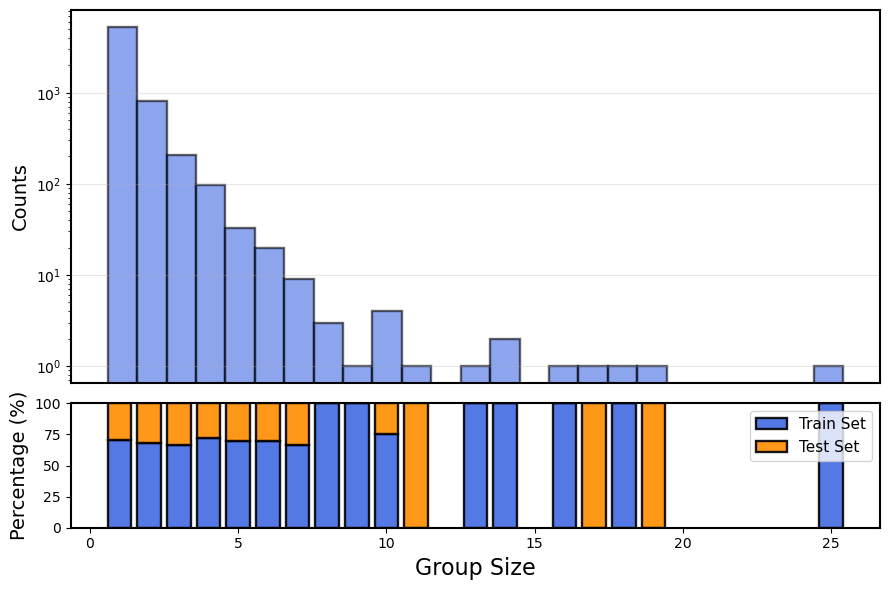

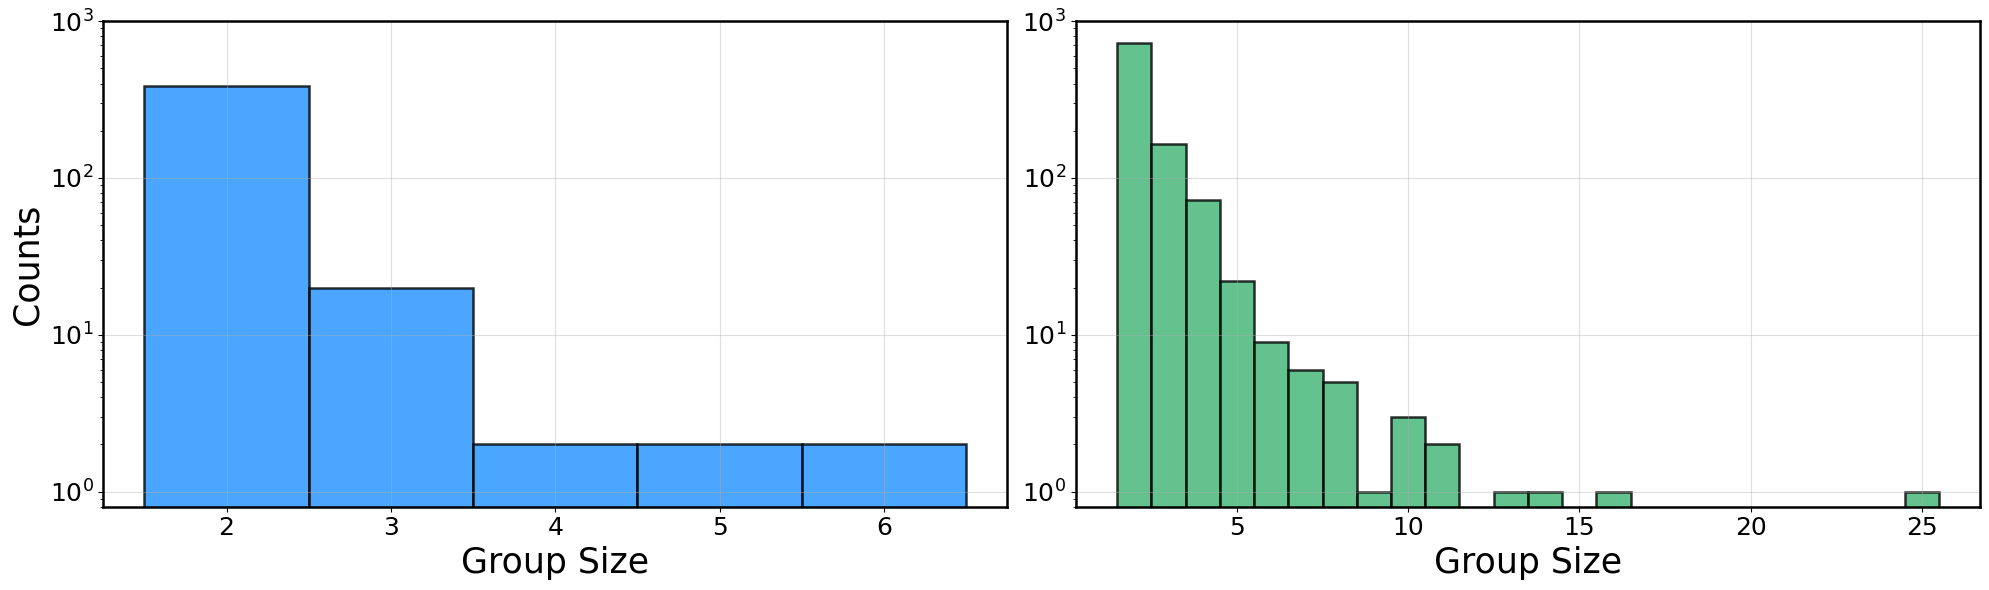

In [8]:
if __name__ == "__main__":
    # Load data
    data = load_data(FILE_PATH)

    # Parse reactions
    (substrate_ec_pairs, product_ec_pairs, row_indices_substrate_ec,
     row_indices_product_ec, products_per_substrate_ec, substrates_per_product_ec, 
     substrates, ecs, products) = parse_reactions(data)

    # Compute EC counts (needed later for histogram analysis)
    substrate_ec_count = Counter(substrate_ec_pairs)
    product_ec_count = Counter(product_ec_pairs)

    # Find duplicates
    substrate_ec_duplicates, substrate_subgroups = find_duplicates(
        substrate_ec_pairs, row_indices_substrate_ec)
    product_ec_duplicates, product_subgroups = find_duplicates(
        product_ec_pairs, row_indices_product_ec)

    # Print summary
    print("\nSummary:")
    print(f"Total (substrate, EC) duplicates: {len(substrate_ec_duplicates)}")
    print(f"Total (product, EC) duplicates: {len(product_ec_duplicates)}")
    print()
    
    # Prepare and split the dataset
    (train_set, test_set, final_subgroups, train_subgroups, test_subgroups, 
    substrate_subgroups, product_subgroups) = prepare_and_split_subgroups(
        substrate_subgroups,
        product_subgroups,
        dataset_size=DATASET_SIZE,
        mode="BOTH",  # or "PRODUCT", "SUBSTRATE"
        train_ratio=0.7,
        seed=RANDOM_SEED
    )


    substrate_ec_dup_counts, product_ec_dup_counts = analyze_and_print_histograms(
        substrate_ec_count,
        product_ec_count,
        final_subgroups,
        train_subgroups,
        test_subgroups,
        data_points=list(range(DATASET_SIZE))
    )

    # Train/test sizes for plotting
    train_group_sizes = [len(g) for g in train_subgroups]
    test_group_sizes = [len(g) for g in test_subgroups]

    # Call the new separated plots
    plot_group_size_distributions(
        final_subgroups,
        train_group_sizes,
        test_group_sizes
    )

    plot_ec_duplicate_histograms(
        substrate_ec_dup_counts,
        product_ec_dup_counts
    )